In [1]:
!pip3 install pyfunctional arrow
%matplotlib notebook

import json
import arrow
import warnings
from arrow.factory import ArrowParseWarning
import matplotlib
import matplotlib.pyplot as plt
import numpy

warnings.simplefilter("ignore", ArrowParseWarning)

server_ids = [
    "ecotype-36",
    "ecotype-37",
    "ecotype-38",
    "ecotype-39",
    "ecotype-40",
    "ecotype-41",
    "ecotype-42",
    "ecotype-43",
    "ecotype-44",
    "ecotype-45",
    "ecotype-46",
    "ecotype-47",
    "ecotype-48",
]
targeted_server = "ecotype-44"

selected_time_interval = [
    ('2019-08-02T00:00:00Z', '2019-08-04T00:00:00Z'),
    ('2019-08-05T12:00:00Z', '2019-08-06T12:00:00Z'),
]

data_file_path = "../data_validation.json"
date_format = "YYYY-MM-DDTHH:mm:ss"

In [2]:
with open(data_file_path) as f:
    data = json.load(f)

In [3]:
all_epochs = [arrow.get(d_str, date_format).timestamp for d_str in data["timestamps"]]
    
selected_time_interval_epochs = [
    (arrow.get(a, date_format).timestamp, arrow.get(b, date_format).timestamp)
    for (a, b) in selected_time_interval
]

#print(all_epochs)
print(selected_time_interval_epochs)

selected_epochs = [
    e
    for e in all_epochs
    #if len([1 for (a, b) in selected_time_interval_epochs if (a <= e and b >= e)]) > 0
    if any([a <= e and b >= e for (a, b) in selected_time_interval_epochs])
]

print(f"I will work on {len(selected_epochs)} / {len(all_epochs)} of the total time intervals")

[(1564704000, 1564876800), (1565006400, 1565092800)]
I will work on 0 / 190 of the total time intervals


In [4]:
x_data = sorted(selected_epochs)
series = {}

air_return_data = data["sensors_data"]["inrow_unit_return_air_temp"]


air_return_temp = [
    temp
    for (ts, temp) in zip(air_return_data["timestamps"], air_return_data["means"])
    if arrow.get(ts, date_format).timestamp in selected_epochs
]

for server_id in server_ids:
    server_data = data.get("consumptions").get(server_id)
    zip_data = zip(server_data.get("timestamps"), 
                   server_data.get("means"),
                   server_data.get("temperatures"))
    sorted_zip_data = sorted(zip_data,
                            key=lambda t3: t3[0])

    #print([arrow.get(t3[0], date_format).timestamp - min(all_epochs) for t3 in sorted_zip_data])

    server_consumptions = [
        b
        for (a, b, c) in sorted_zip_data
        if arrow.get(a, date_format).timestamp in selected_epochs
    ]
    server_temperatures = [
        c
        for (a, b, c) in sorted_zip_data
        if arrow.get(a, date_format).timestamp in selected_epochs
    ]
    series[server_id] = {
        "consumption": server_consumptions,
        "temperature": server_temperatures,
    }

    
avg_servers_consumption = []
for tn in zip(*[series[server_id]["consumption"] for server_id in server_ids]):
    avg_servers_consumption += [numpy.mean(tn)]
    
avg_servers_temperatures = []
for tn in zip(*[series[server_id]["temperature"] for server_id in server_ids]):
    avg_servers_temperatures += [numpy.mean(tn)]

<IPython.core.display.Javascript object>


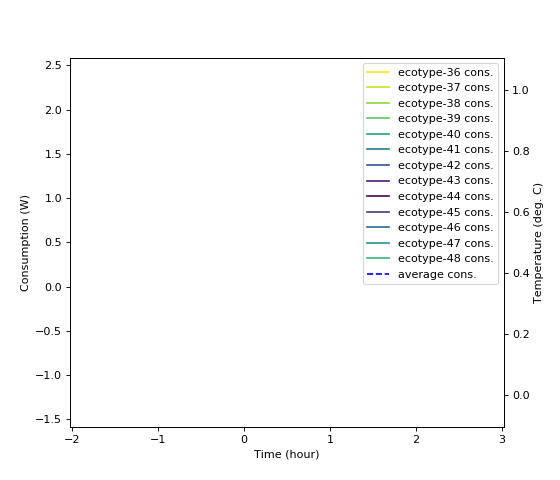

<IPython.core.display.Javascript object>


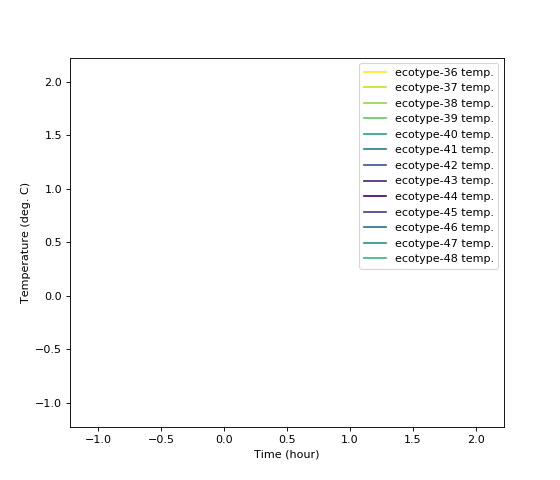

In [5]:
import matplotlib.colors as mcolors
from matplotlib import cm

fig, ax = plt.subplots(figsize=(7, 6), dpi= 80)

x_data = [arrow.get(x).datetime for x in x_data]
    
cmap = cm.get_cmap('viridis', len(server_ids))

colors = {}

num_targeted_server = int(targeted_server.split("-")[1])
sorted_server_ids = sorted(server_ids, key=lambda x: (num_targeted_server- int(x.split("-")[1]))**2)

for (server_name, color) in zip(sorted_server_ids, cmap.colors):
    colors[server_name] = color    

for server_name, server_dict in series.items():
    p = ax.plot(
        x_data,
        server_dict.get("consumption"),
        label=f'{server_name} cons.',
        color=colors[server_name],
    )
    colors[server_name] = p[0].get_color()
    
ax.plot(
    x_data,
    avg_servers_consumption,
    linestyle="--",
    label=f'average cons.',
    color="blue",
)
    
    
plt.ylabel('Consumption (W)')
plt.xlabel('Time (hour)')

plt.legend()

ax2 = ax.twinx() 
ax2.plot(x_data, 
        series[targeted_server].get("temperature"),
        linestyle="--",
        label=f'{targeted_server} temperature.',
        c=colors[targeted_server])

ax2.plot(x_data, 
        air_return_temp,
        linestyle="--",
        label=f'air return temperature.',
        c="red")

ax.plot(
    x_data,
    avg_servers_temperatures,
    linestyle="--",
    label=f'average temperature.',
    color="orange",
)

plt.ylabel('Temperature (deg. C)')
plt.xlabel('Time (hour)')

fig, ax = plt.subplots(figsize=(7, 6), dpi= 80)
for server_name, server_dict in series.items():
    ax.plot(x_data,
            server_dict.get("temperature"),
#            linestyle="--",
#            marker='o',
            label=f'{server_name} temp.',
            c=colors[server_name])

plt.legend()

plt.ylabel('Temperature (deg. C)')
plt.xlabel('Time (hour)')

plt.show()

In [6]:
selected_temperature_interval = (20, 45.5)

series = {}

with open(data_file_path) as f:
    data = json.load(f)
    
    targeted_server_data = data["consumptions"][targeted_server]
    zipped_timestamp_temperature = zip(
        targeted_server_data["timestamps"], 
        targeted_server_data["temperatures"],
        targeted_server_data["means"]
    )
    filtered_ts = [
        arrow.get(ts, date_format).timestamp
        for (ts, temp, cons) in zipped_timestamp_temperature
        #if temp >= selected_temperature_interval[0] and temp <= selected_temperature_interval[1]
        #if cons == 0
    ]
    
    print(f"{len(filtered_ts)} / {len(server_data['timestamps'])}")
    
    air_return_data = data["sensors_data"]["inrow_unit_return_air_temp"]
          
                      
    air_return_temp = [
        temp
        for (ts, temp) in zip(air_return_data["timestamps"], air_return_data["means"])
        if arrow.get(ts, date_format).timestamp in filtered_ts
    ]
          
    print(len(air_return_temp))
          
    for server_id in server_ids:
          server_data = data["consumptions"][server_id]
          
          server_points = [
              (target_server_temp, temp)
              #for (ts, temp, cons) in zip(server_data["timestamps"], server_data["temperatures"], server_data["means"])
              for (ts, temp, cons, target_server_temp, air_return_temp) in zip(server_data["timestamps"], server_data["temperatures"], server_data["means"],targeted_server_data["temperatures"], air_return_temp)
              if arrow.get(ts, date_format).timestamp in filtered_ts
          ]
          series[server_id] = {
              "x": [x for (x, y) in server_points],
              "y": [y for (x, y) in server_points],
          }


182 / 182
182


<IPython.core.display.Javascript object>


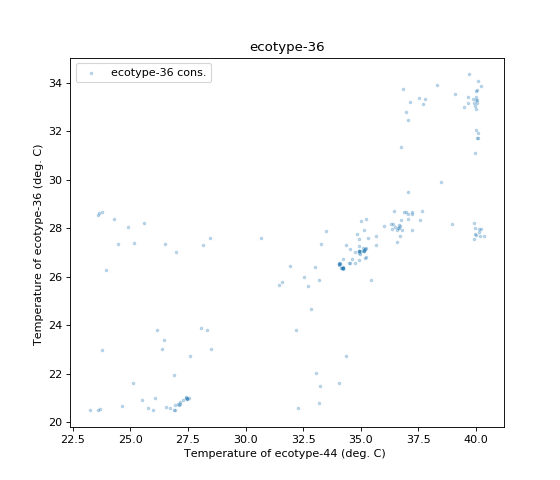

<IPython.core.display.Javascript object>


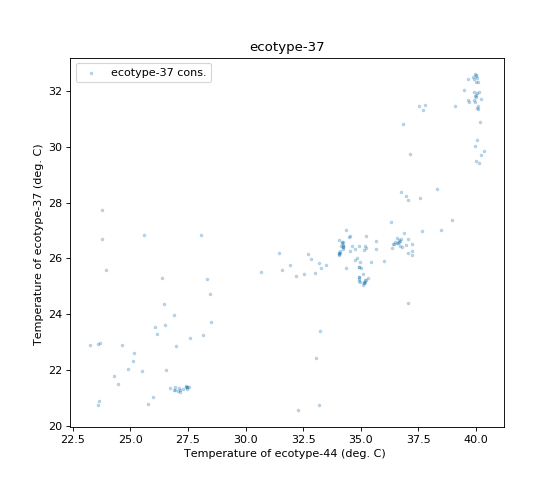

<IPython.core.display.Javascript object>


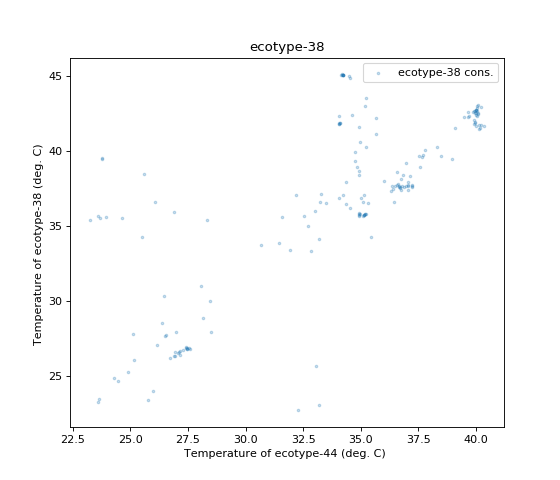

<IPython.core.display.Javascript object>


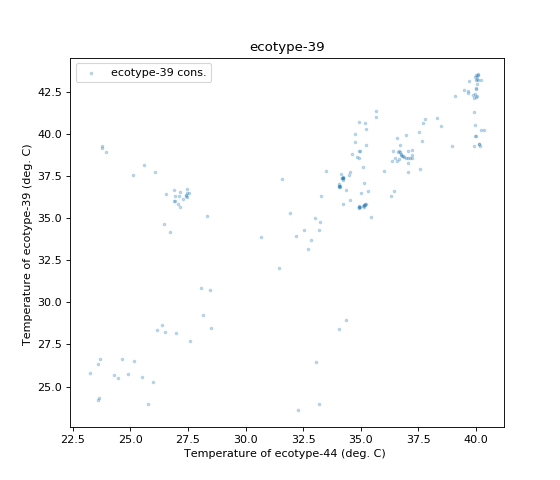

<IPython.core.display.Javascript object>


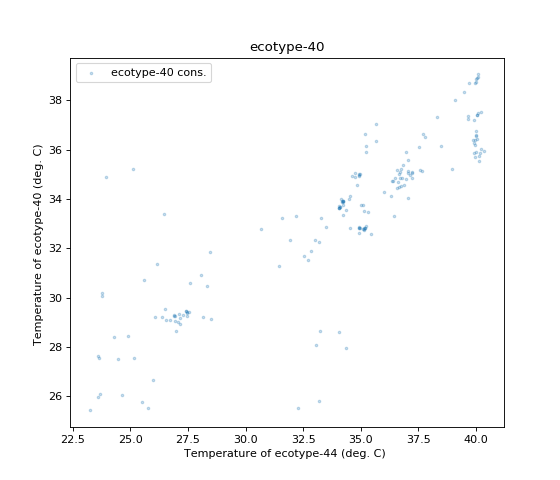

<IPython.core.display.Javascript object>


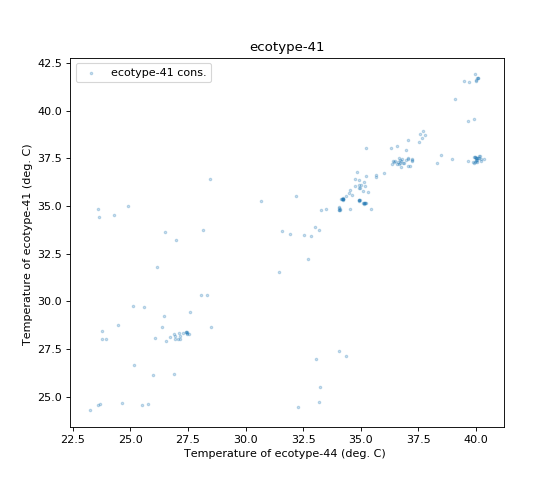

<IPython.core.display.Javascript object>


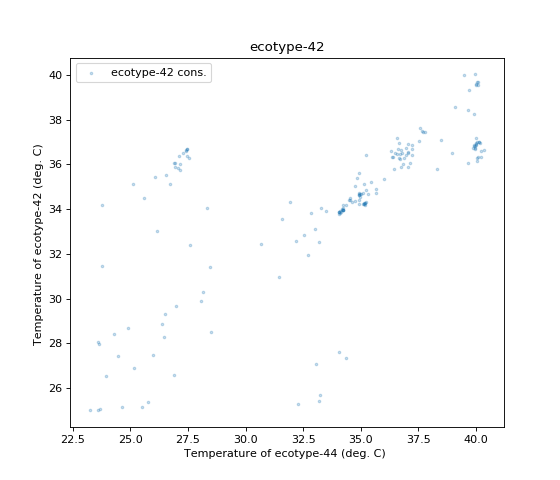

<IPython.core.display.Javascript object>


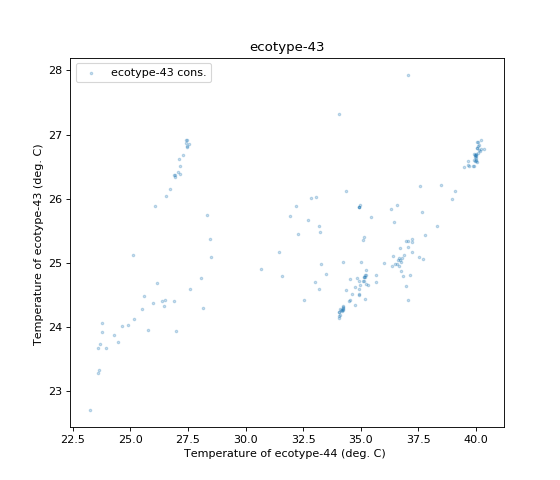

<IPython.core.display.Javascript object>


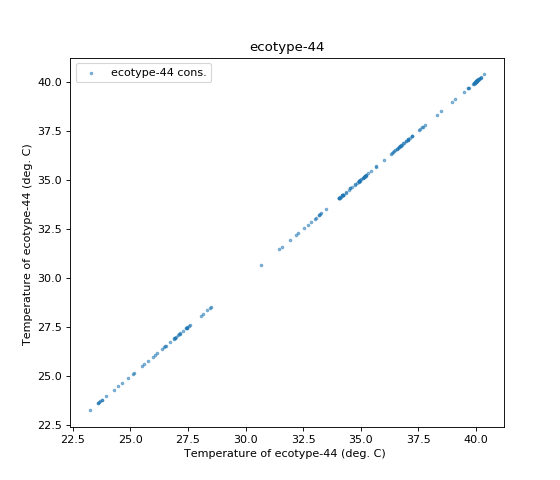

<IPython.core.display.Javascript object>


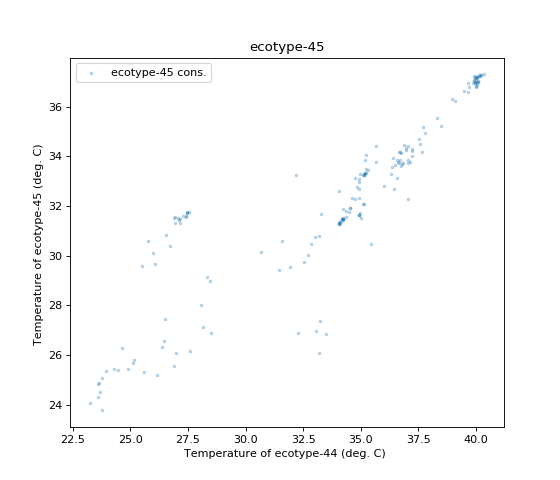

<IPython.core.display.Javascript object>


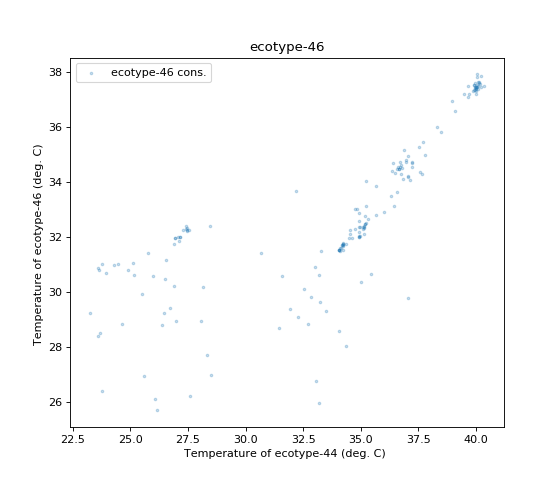

<IPython.core.display.Javascript object>


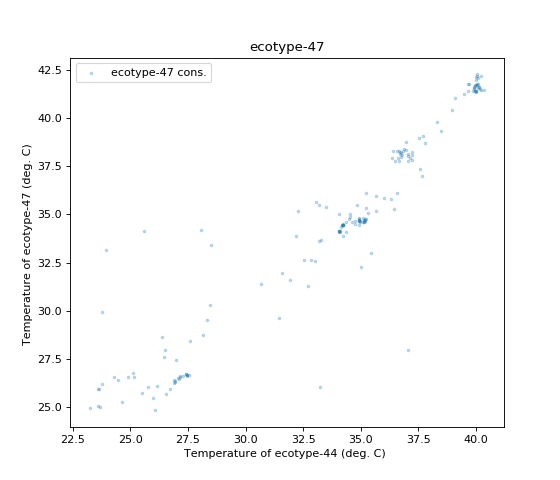

<IPython.core.display.Javascript object>


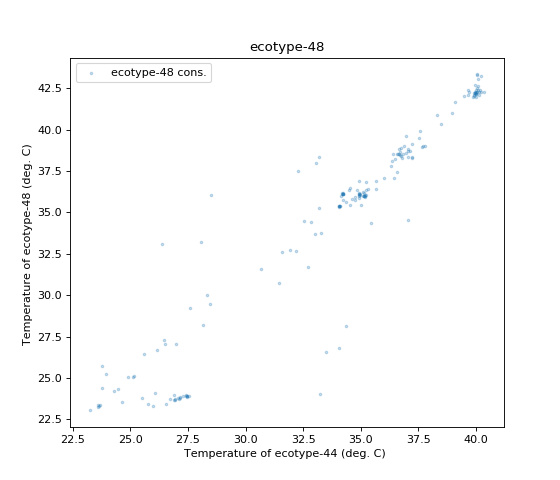

<IPython.core.display.Javascript object>


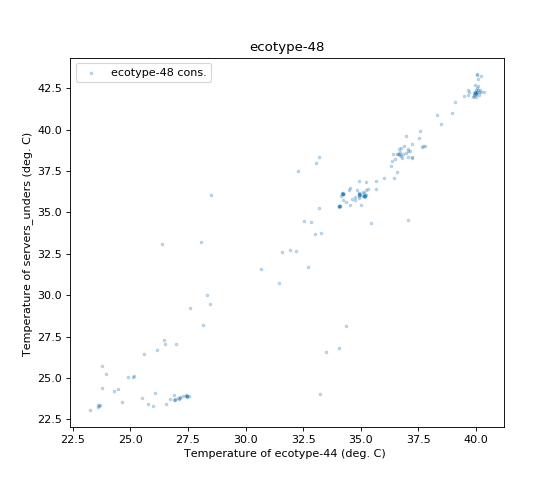

In [7]:
#fig, ax = plt.subplots(figsize=(7, 6), dpi= 80)

x_data = [arrow.get(x).datetime for x in x_data]

for server_name, server_dict in series.items():
    
    fig, ax = plt.subplots(figsize=(7, 6), dpi= 80)

    alpha = 0.5 if server_name == targeted_server else 0.25
    ax.scatter(server_dict.get("x"), server_dict.get("y"), label=f'{server_name} cons.', s=5, alpha=alpha)

    plt.legend()

    plt.xlabel(f'Temperature of {targeted_server} (deg. C) ')
    plt.ylabel(f'Temperature of {server_name} (deg. C) ')
    plt.title(f"{server_name}")

# WITH average of servers under the targeted server
fig, ax = plt.subplots(figsize=(7, 6), dpi= 80)

alpha = 0.5 if server_name == targeted_server else 0.25
ax.scatter(server_dict.get("x"), server_dict.get("y"), label=f'{server_name} cons.', s=5, alpha=alpha)

plt.legend()

plt.xlabel(f'Temperature of {targeted_server} (deg. C) ')
plt.ylabel(f'Temperature of servers_unders (deg. C) ')
plt.title(f"{server_name}")
    
plt.show()